# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import ensemble as en
from sklearn import neighbors as nb
from sklearn import linear_model as lm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pickle
from flask import Flask, request, Response

# Helper functions

In [2]:
def recall_at_k(data, k):
    # Create ranking
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

def precision_at_k(data, k):
    # Create ranking
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def curves(x_val, yhat, y_val, k):

    # Accumulative Gain
    results = pd.DataFrame()
    results['prediction'] = yhat[:,1].tolist()
    results['real'] = y_val.tolist()

    # Sorting the predicted values along with the actual labels
    results = results.sort_values( 'prediction', ascending=False )

    # Percentage of intereset ( Propensity Score )
    results['real_cum'] = results['real'].cumsum() 
    results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()  # Converting to percentage

    # Percentage of Base ( Clients )
    results['base'] = range( 1, len( results ) + 1  )
    results['base_cum_perc'] = 100*results['base']/len( results )

    # Basline model
    results['baseline'] = results['base_cum_perc']

    # Plotting cumulative gains curve with legend
    plt.figure(figsize=[15,6])
    plt.subplot(1,2,1)
    sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results, label='Class 1' )
    sns.lineplot( x='base_cum_perc', y='baseline', data=results, linestyle='--', color='grey', label='Baseline')
    plt.title('Cumulative Gains Curve')
    plt.grid(True)

    # Lift Curve
    results = pd.DataFrame()
    results['prediction'] = yhat[:,1].tolist()
    results['real'] = y_val.tolist()

    # ordering by prediction
    results = results.sort_values( 'prediction', ascending=False )

    # Percentage of intereset ( Propensity Score )
    results['real_cum'] = results['real'].cumsum() 
    results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

    # Percentage of Base ( Clients )
    results['base'] = range( 1, len( results ) + 1  )
    results['base_cum_perc'] = 100*results['base']/len( results )

    # Basline model
    results['baseline'] = 1

    # Lift Calculation
    results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

    plt.subplot(1,2,2)
    sns.lineplot( x='base_cum_perc', y='lift', data=results, label='Class 1' )
    sns.lineplot( x='base_cum_perc', y='baseline', data=results, linestyle='--', color='grey', label='Baseline' )
    plt.title('Lift Curve')
    plt.grid(True)

    plt.show()

    # copy data
    df7 = x_val.copy()
    df7['response'] = y_val.copy()

    # restoring custumer id
    df7 = df7.reset_index()
    df7 = df7.rename(columns={'index': 'id'})

    # propensity score
    df7['score'] = yhat[: , 1].tolist()

    # sort clients by propensity score
    df7 = df7.sort_values('score', ascending=False)

    print(f"A precisão do modelo com {k} chamadas é {precision_at_k(df7, k=k)*100:.2f}%")
    print(f"O recall do modelo com {k} chamadas é {recall_at_k(df7, k=k)*100:.2f}%")

# 0.1 Loading Dataset

In [3]:
df_raw = pd.read_csv(r'C:\Users\Matheus\Documents\projects\propensao_de_compra\data\train.csv')

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1 Data Dimension

In [6]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Data Descriptive

In [9]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'])

In [10]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispertion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() -  x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [11]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engeneering

In [12]:
df2 = df1.copy()

In [13]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                                       if x == '1-2 Year' else 'below_1_year')

In [14]:
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 Data Filtering

In [15]:
df3 = df2.copy()

# 4.0 EDA

In [16]:
df4 = df3.copy()

## 4.1 Univariate Analysis

Text(0.5, 0, 'Resposta')

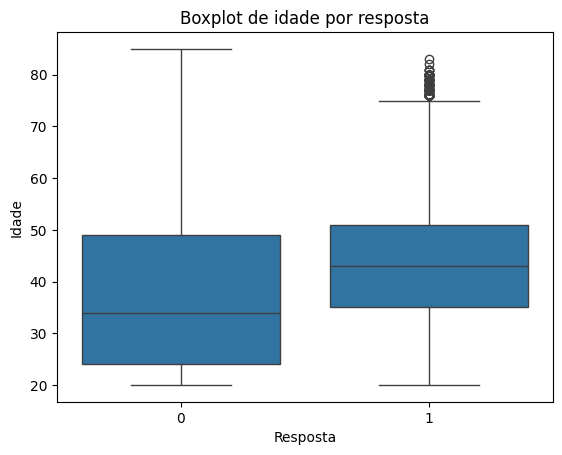

In [17]:
# age
sns.boxplot(x='response', y='age', data=df4)
plt.title('Boxplot de idade por resposta')
plt.ylabel('Idade')
plt.xlabel('Resposta')

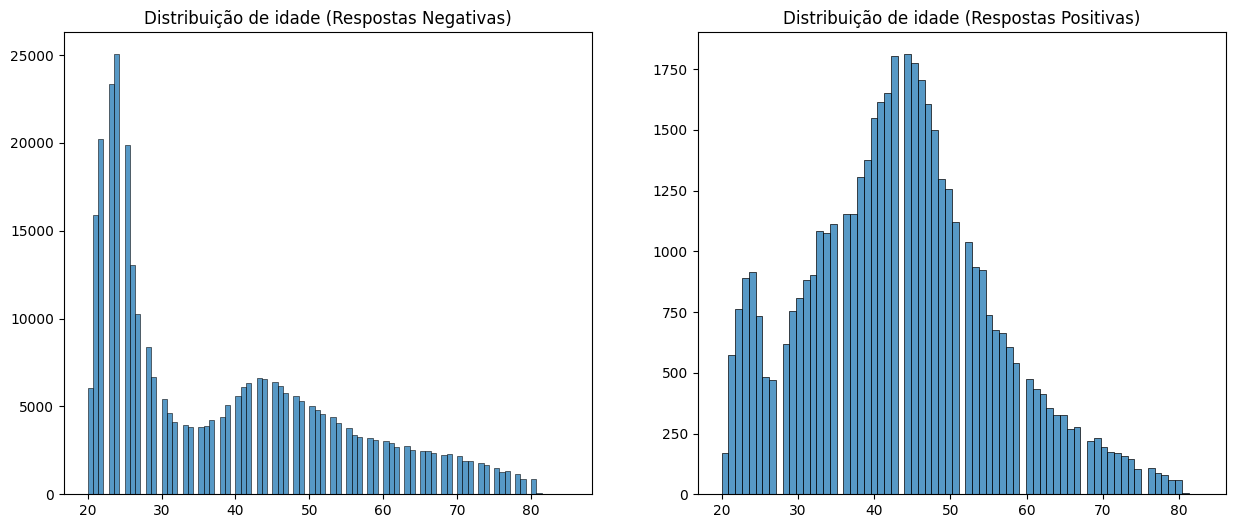

In [18]:
aux00 = df4.loc[df4['response'] == 0, 'age']
aux01 = df4.loc[df4['response'] == 1, 'age']

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sns.histplot( aux00 )

plt.title('Distribuição de idade (Respostas Negativas)')
plt.ylabel('')
plt.xlabel('')

plt.subplot(1,2,2)
sns.histplot( aux01 )

plt.title('Distribuição de idade (Respostas Positivas)')
plt.ylabel('')
plt.xlabel('')

plt.show()

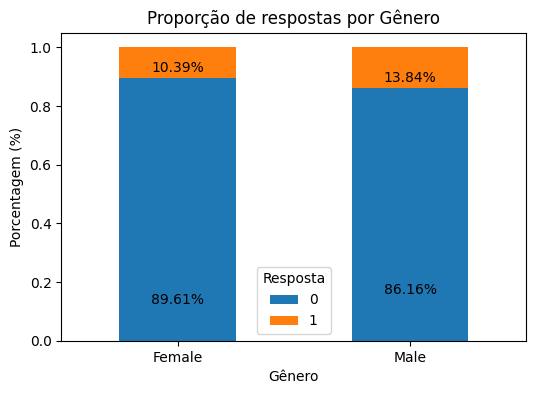

In [19]:
# gender
aux = pd.crosstab(df4['gender'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('Proporção de respostas por Gênero')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Gênero')
plt.legend(title='Resposta')
plt.xticks(rotation=0)

for i in range(len(aux)):
    for j, value in aux.iloc[i].items():
        plt.text(i, 1 - value + 0.02, f'{value*100:.2f}%', ha='center')

plt.show()


In [20]:
j, value = aux.iloc[0].items()
j

(0, 0.8960975888469889)

Analisando a variável driving_licence foi contatado que 87% das pessoas que dirigem não tem interesse em seguro de carro

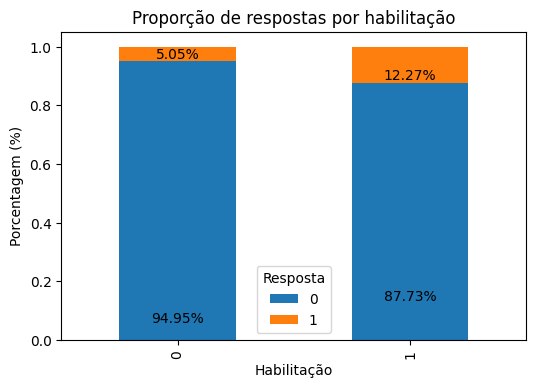

In [21]:
# driving license
aux = pd.crosstab(df4['driving_license'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('Proporção de respostas por habilitação')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Habilitação')
plt.legend(title='Resposta')

for i, row in aux.iterrows():
    for j, value in row.items():
        plt.text(i, 1 - value + 0.01, f'{value*100:.2f}%', ha='center')
plt.show()

In [22]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


Ao retirarmos a região outlier podemos perceber que existe uma pequena divisão onde certas região tem maior tendencia a não se interessarem por seguros, sendo que existem 23 regiões com uma taxa de resposta positiva acima da média

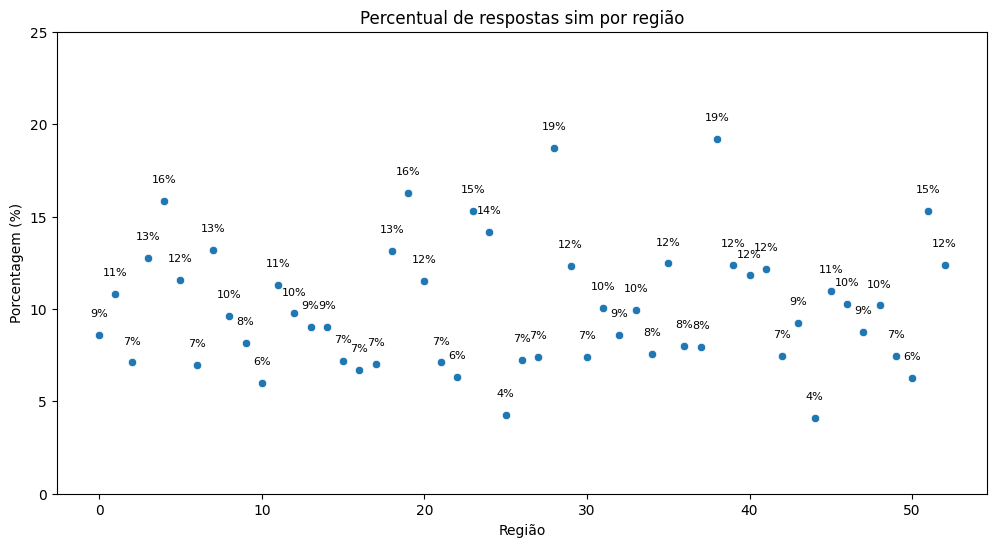

In [23]:
# region code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
aux01 = pd.pivot_table(aux, index='region_code', columns='response', values='id', aggfunc='sum')
aux01['% de respostas 1'] = (aux01[1] / (aux01[1] + aux01[0])) * 100
aux01 = aux01.reset_index()
aux01.columns = ['region_code', 'response_1', 'response_0', 'perc_1']

plt.figure(figsize=(12, 6))
sns.scatterplot(x='region_code', y='perc_1', data=aux01)
plt.title('Percentual de respostas sim por região')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Região')
plt.ylim(0, 25)
for i, row in aux01.iterrows():
    plt.text(row['region_code'], row['perc_1'] + 1, f'{row["perc_1"]:.0f}%', ha='center', fontsize=8)

plt.show()

In [24]:
print(f'A média de respostas 1 por região é {(aux01["perc_1"].mean()):.2f} %')
print(f'O desvio padrão de respostas 1 por região é {(aux01["perc_1"].std()):.2f}')

A média de respostas 1 por região é 10.08 %
O desvio padrão de respostas 1 por região é 3.39


Regiões: 38, 28, 19, 4, 23, 51, 24	tem desempenho acima de um devio padrão da média para respostas positivas

In [25]:
aux01.sort_values('perc_1', ascending=False)

,region_code,response_1,response_0,perc_1
38,38.0,1637,389,19.200395
28,28.0,86498,19917,18.716346
19,19.0,1285,250,16.286645
4,4.0,1516,285,15.824542
23,23.0,1660,300,15.306122
51,51.0,155,28,15.300546
24,24.0,2073,342,14.161491
7,7.0,2847,432,13.174748
18,18.0,4475,678,13.157384
3,3.0,8070,1181,12.766187


Variável previously insured pode representar um vazamento de dados já que é altamente correlacionada, pois pessoas que já possuem o seguro praticamente sempre irão responder negativamente

In [26]:
# previously insured
print(pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1))

response                   0         1
previously_insured                    
0                   0.774546  0.225454
1                   0.999095  0.000905


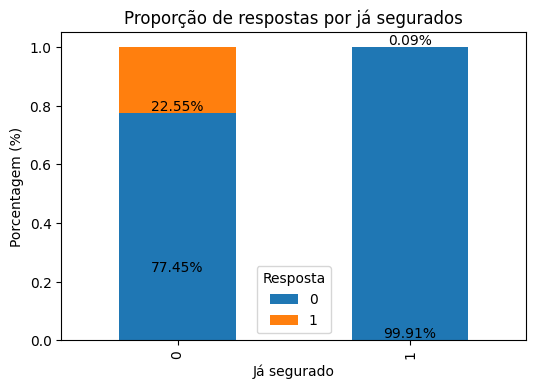

In [27]:
aux = pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('Proporção de respostas por já segurados')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Já segurado')
plt.legend(title='Resposta')
for i, row in aux.iterrows():
    for j, value in row.items():
        plt.text(i, 1 - value + 0.01, f'{value*100:.2f}%', ha='center')
plt.show()

É possivel perceber que a variável vehicle age é descriminatória pois quanto mais antigo o carro maior o interesse em obter um seguro

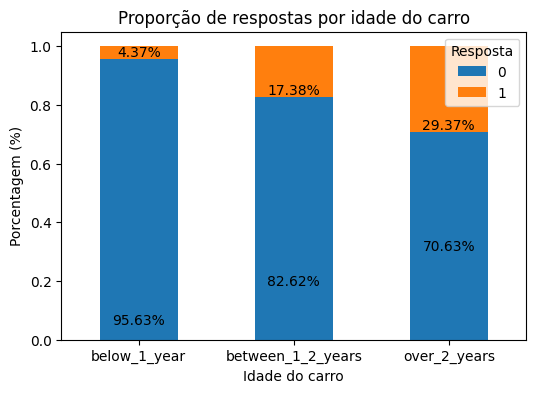

In [28]:
# vehicle age
aux = pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('Proporção de respostas por idade do carro')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Idade do carro')
plt.legend(title='Resposta')
plt.xticks(rotation=0)

for i in range(len(aux)):
    for j, value in aux.iloc[i].items():
        plt.text(i, 1 - value + 0.01, f'{value*100:.2f}%', ha='center')

plt.show()

Ao analisar  variável annual_premium podemos perceber que provavelmente é uma feature que não irá agreagar a um modelo classificatório, já que sua distribuição não muda dividindo os dados entre as duas variaveis resposta

<Axes: xlabel='response', ylabel='annual_premium'>

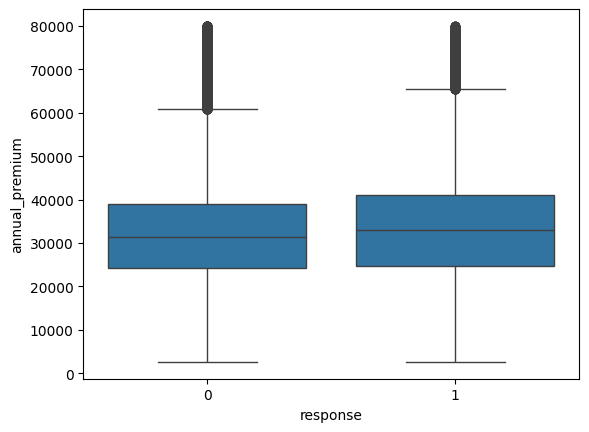

In [29]:
# annual premium
aux = df4.loc[df4['annual_premium'] < 80000, :]
sns.boxplot(x='response', y='annual_premium', data=aux)

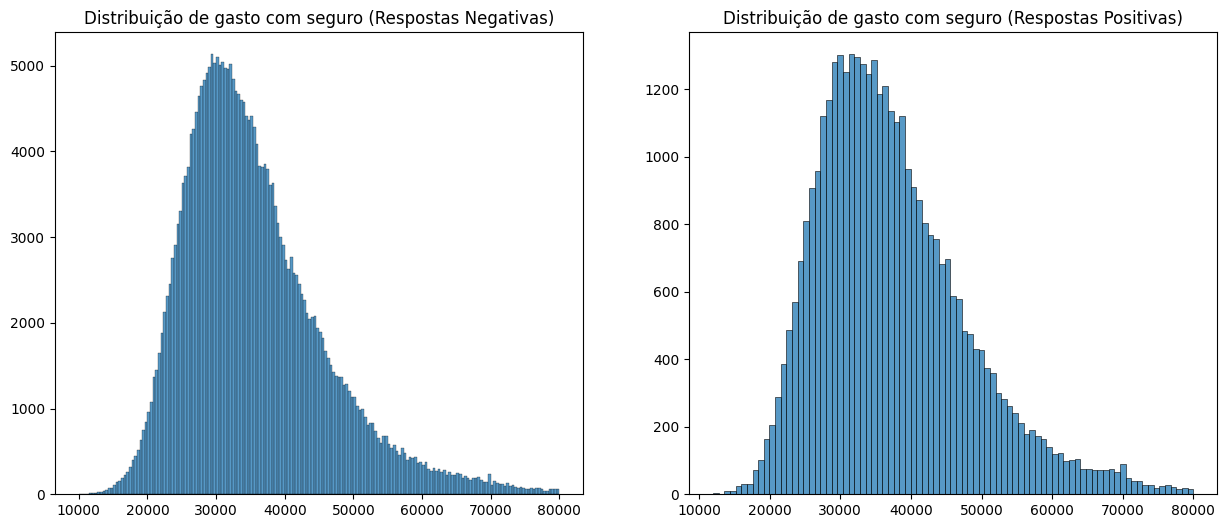

In [30]:
aux = df4.loc[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000), :]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sns.histplot( aux00 )

plt.title('Distribuição de gasto com seguro (Respostas Negativas)')
plt.ylabel('')
plt.xlabel('')

plt.subplot(1,2,2)
sns.histplot( aux01 )

plt.title('Distribuição de gasto com seguro (Respostas Positivas)')
plt.ylabel('')
plt.xlabel('')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


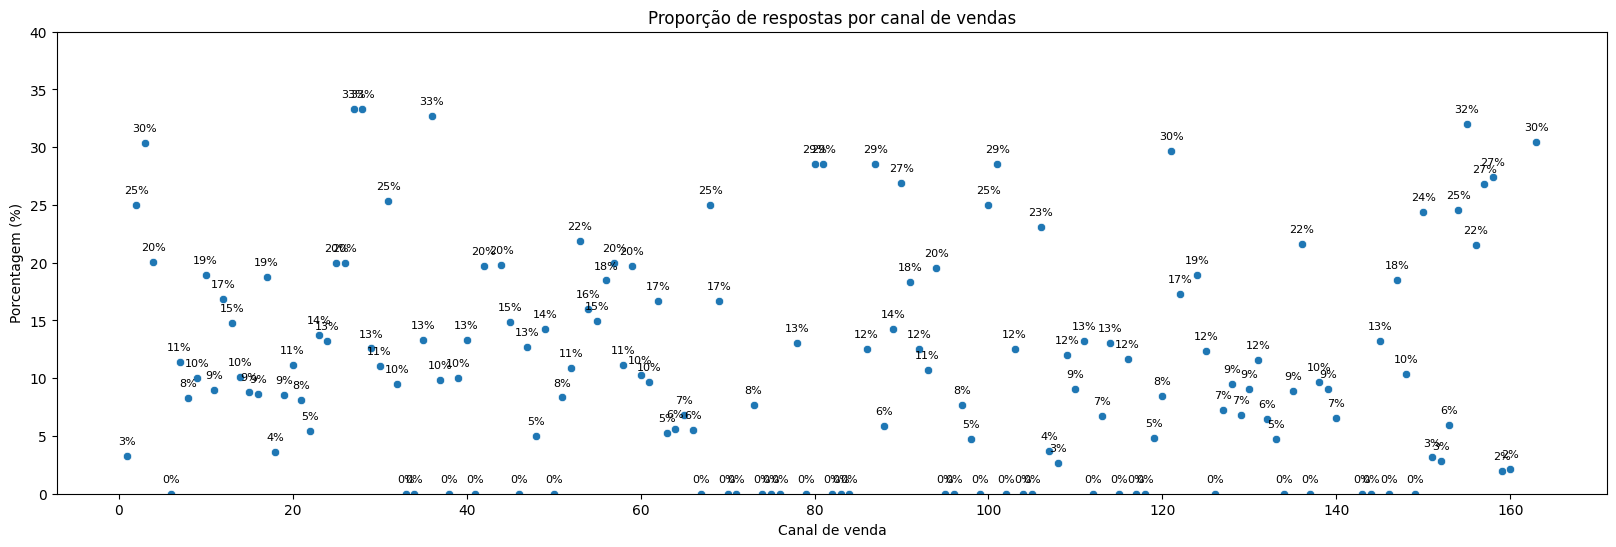

In [31]:
# policy sales channel
aux = df4[['id', 'policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()
aux01 = pd.pivot_table(aux, index='policy_sales_channel', columns='response', values='id', aggfunc='sum')
aux01[1] = aux01[1].fillna(0)
aux01['% de respostas 1'] = (aux01[1] / (aux01[1] + aux01[0])) * 100
aux01 = aux01.reset_index()
aux01.columns = ['policy_sales_channel', 'response_1', 'response_0', 'perc_1']

plt.figure(figsize=(20, 6))
sns.scatterplot(x='policy_sales_channel', y='perc_1', data=aux01)
plt.title('Proporção de respostas por canal de vendas')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Canal de venda')
plt.ylim(0, 40)
for i, row in aux01.iterrows():
    plt.text(row['policy_sales_channel'], row['perc_1'] + 1, f'{row["perc_1"]:.0f}%', ha='center', fontsize=8)

plt.show()

In [32]:
print(f'A média de respostas 1 por região é {(aux01["perc_1"].mean()):.2f} %')
print(f'O desvio padrão de respostas 1 por região é {(aux01["perc_1"].std()):.2f}')

A média de respostas 1 por região é 11.11 %
O desvio padrão de respostas 1 por região é 9.28


In [33]:
aux01[aux01['perc_1'] > 20.3].sort_values('perc_1', ascending=False)

,policy_sales_channel,response_1,response_0,perc_1
25,27.0,2.0,1.0,33.333333
26,28.0,2.0,1.0,33.333333
34,36.0,35.0,17.0,32.692308
148,155.0,839.0,395.0,32.009724
154,163.0,2013.0,880.0,30.418251
2,3.0,364.0,159.0,30.401530
116,121.0,45.0,19.0,29.687500
76,80.0,10.0,4.0,28.571429
77,81.0,10.0,4.0,28.571429
82,87.0,5.0,2.0,28.571429


Analisando a variável vintage percebbermos que essa base de dados é muito hommogenea em relação a quão antigos são os clientes, portanto é uma variável que provaelmente irá contribuir pouco para o modelo

<Axes: xlabel='response', ylabel='vintage'>

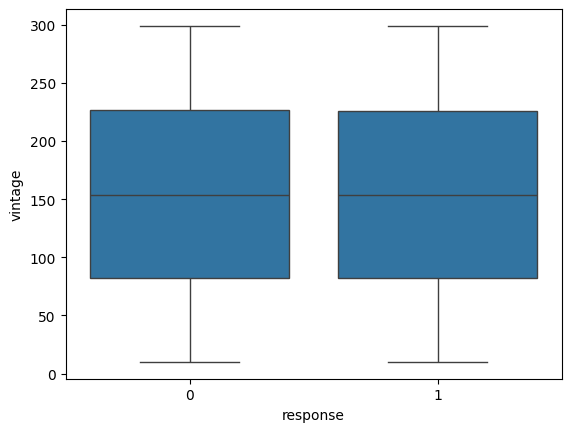

In [34]:
# vintage
sns.boxplot(x='response', y='vintage', data=df4)

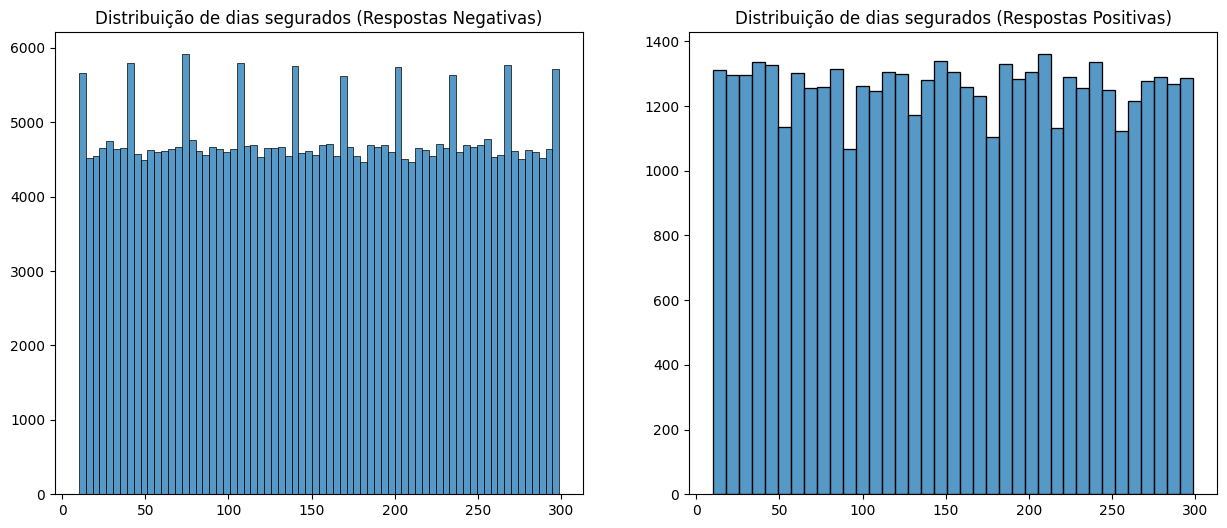

In [35]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
aux01 = df4.loc[df4['response'] == 1, 'vintage']

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sns.histplot( aux00 )

plt.title('Distribuição de dias segurados (Respostas Negativas)')
plt.ylabel('')
plt.xlabel('')

plt.subplot(1,2,2)
sns.histplot( aux01 )

plt.title('Distribuição de dias segurados (Respostas Positivas)')
plt.ylabel('')
plt.xlabel('')

plt.show()

# 5.0 Data Preparation

In [36]:
df5 = df4.copy()

In [37]:
X = df4.drop ('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [118]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump( ss, open(r'C:\Users\Matheus\Documents\projects\propensao_de_compra\features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2 Rescaling

In [119]:
# age
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump( mms_age, open(r'C:\Users\Matheus\Documents\projects\propensao_de_compra\features/age_scaler.pkl', 'wb' ) )

# vintage
mms_vintage = pp.MinMaxScaler()
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump( mms_vintage, open(r'C:\Users\Matheus\Documents\projects\propensao_de_compra\features/vintage_scaler.pkl', 'wb' ) )

## 5.3 Encoder

In [120]:
# gender - Target encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump( target_encode_gender, open(r'C:\Users\Matheus\Documents\projects\propensao_de_compra\features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target encoding
target_encode_region = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region)
pickle.dump( target_encode_region, open(r'C:\Users\Matheus\Documents\projects\propensao_de_compra\features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frenquency encoding
freq_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(freq_sales_channel)
pickle.dump( freq_sales_channel, open(r'C:\Users\Matheus\Documents\projects\propensao_de_compra\features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4 Validation preparation

In [48]:
# gender
x_val.loc[:, 'gender'] = x_val['gender'].map(target_encode_gender)

# region_code
x_val.loc[:, 'region_code'] = x_val['region_code'].map(target_encode_region)

# vehicle_age
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map(freq_sales_channel)

# vintage
x_val['vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# age
x_val['age'] = mms_age.transform(x_val[['age']].values)

# annual_premium
x_val['annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# fillna
x_val = x_val.fillna(0)

# 6.0 Feature Selection

## 6.1 Feature Importance

In [87]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                         feature  importance
0                        vintage    0.273861
0                 annual_premium    0.244960
0                            age    0.162493
0                    region_code    0.105429
0                 vehicle_damage    0.066323
0           policy_sales_channel    0.061881
0             previously_insured    0.057115
0       vehicle_age_below_1_year    0.013460
0  vehicle_age_between_1_2_years    0.006419
0                         gender    0.005073
0       vehicle_age_over_2_years    0.002487
0                driving_license    0.000501


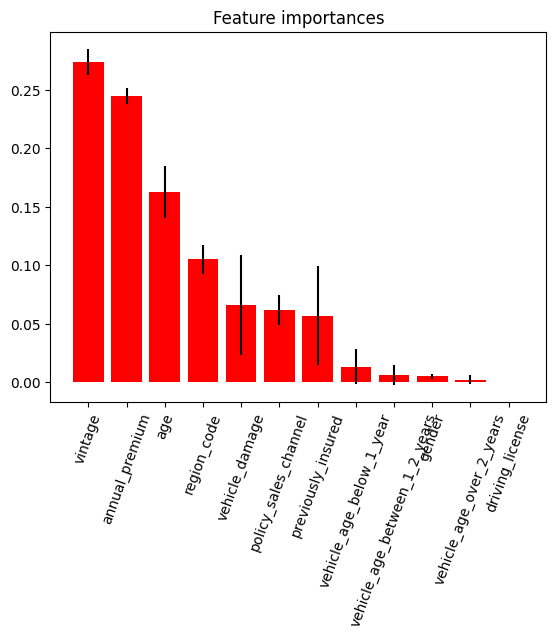

In [88]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print('Feature ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.Figure()
plt.title('Feature importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), x_train_n.columns[indices], rotation=70)
plt.show()

# 7.0 Machine Learning

A partir da feature selection foram mantidas apenas as variáveis que representam pelo menos 0,05 do modelo 

In [49]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel'] 

x_train = df5[cols_selected]
x_val = x_val[cols_selected]

k=20000

## 7.1 Knn

In [90]:
# model definition
knn_model = nb.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Poder de GENERALIZAÇÃO

yhat_knn = knn_model.predict_proba(x_val)

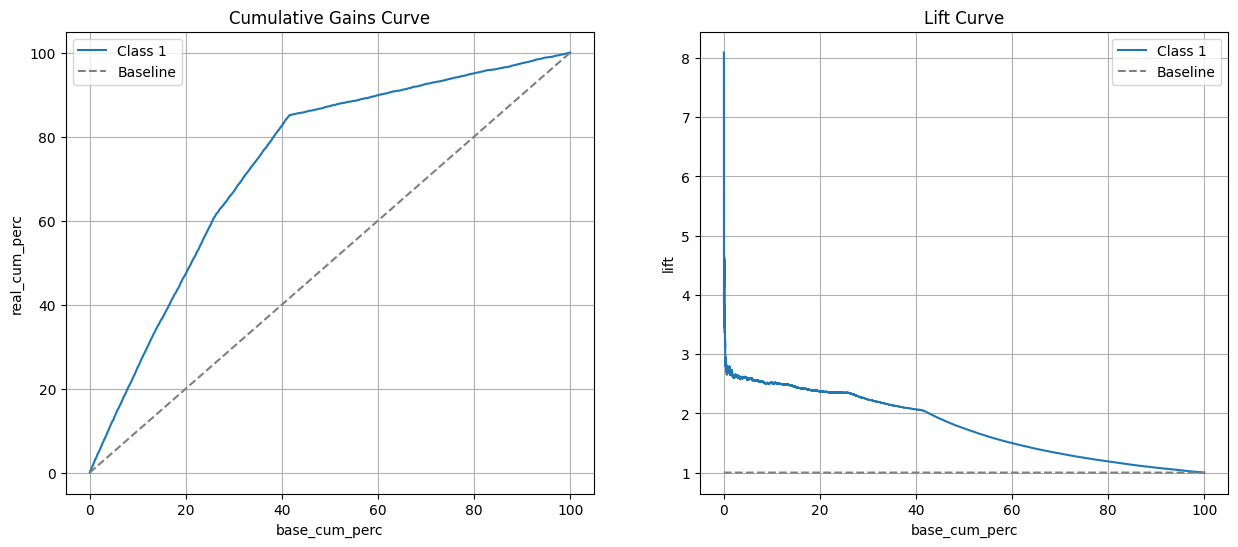

A precisão do modelo com 20000 chamadas é 28.94%
O recall do modelo com 20000 chamadas é 61.43%


In [91]:
curves(x_val, yhat_knn, y_val, k)

## 7.2 Logistic Regression

In [92]:
# model definition
lr_model = lm.LogisticRegression() 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

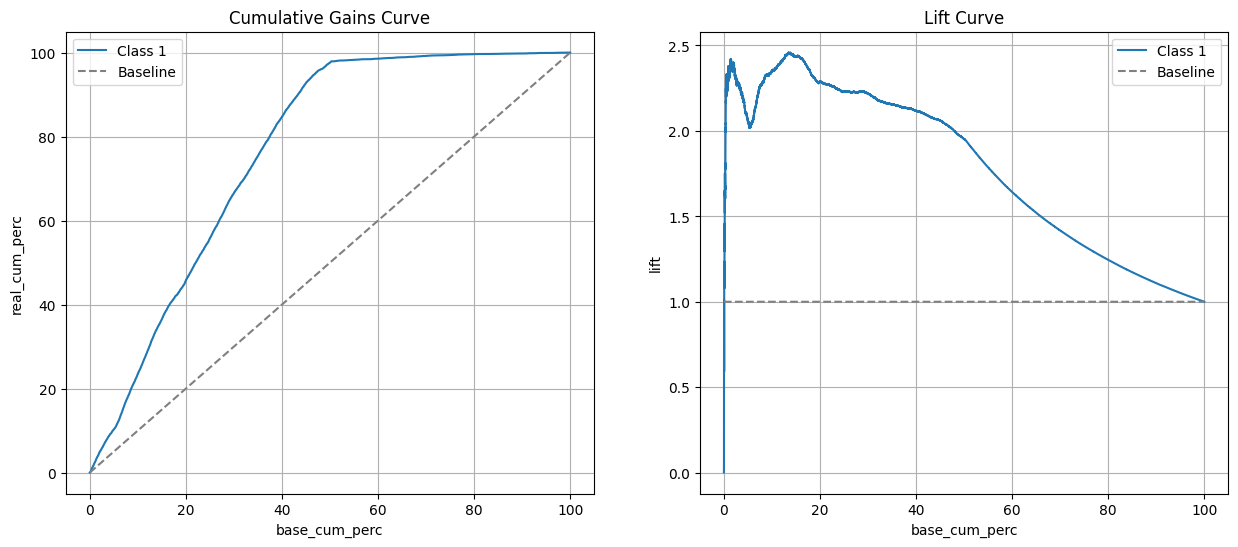

A precisão do modelo com 20000 chamadas é 27.54%
O recall do modelo com 20000 chamadas é 58.47%


In [93]:
curves(x_val, yhat_lr, y_val, k)

## 7.3 Extra Trees Classifier

In [94]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=100, n_jobs=-1) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )

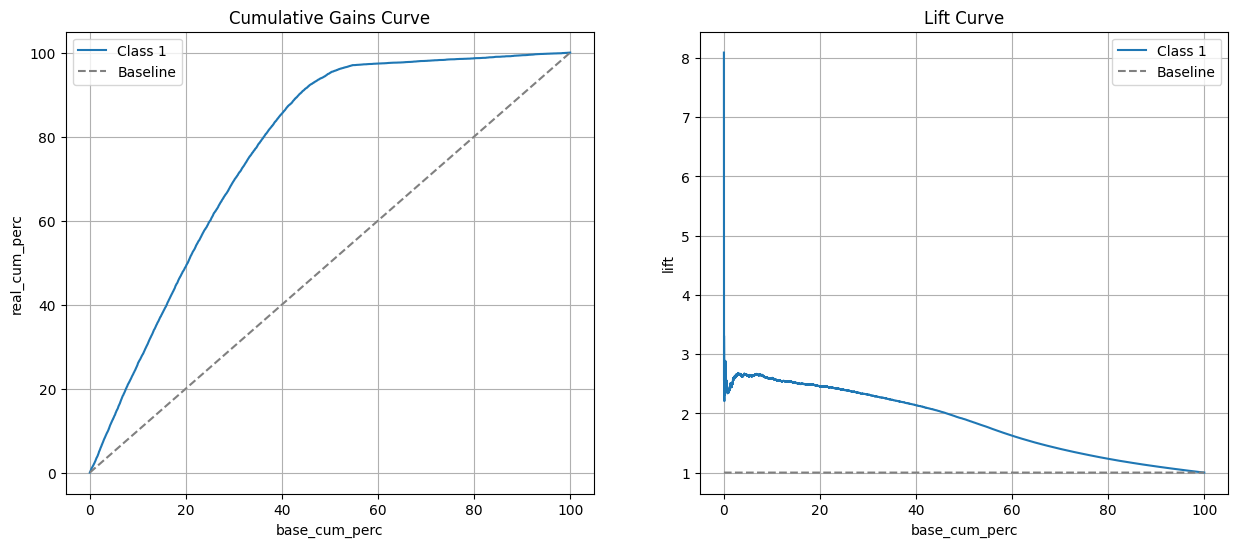

A precisão do modelo com 20000 chamadas é 29.39%
O recall do modelo com 20000 chamadas é 62.39%


In [95]:
curves(x_val, yhat_et, y_val, k)

## 7.4 Randon Forest

In [96]:
# model definition
rf = en.RandomForestClassifier( n_estimators=100, n_jobs=-1) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = et.predict_proba( x_val )

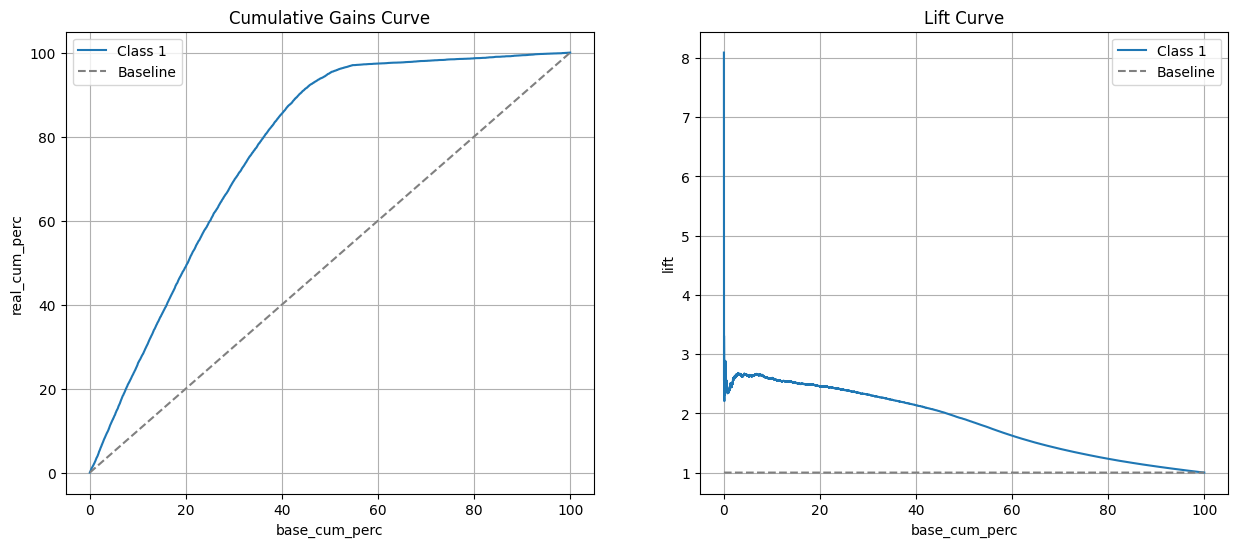

A precisão do modelo com 20000 chamadas é 29.39%
O recall do modelo com 20000 chamadas é 62.39%


In [97]:
curves(x_val, yhat_rf, y_val, k)

# 8.0 Model Tunning

## 8.1 Fine Tunning (Beyes Search)

In [98]:
'''search_space = {
    'n_estimators': Integer(10, 1000),
    'max_depth': Integer(5, 50),
    'min_samples_split': Real(0.01, 1.0),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2'])
}

# Defina o modelo Random Forest Classifier
rf = en.RandomForestClassifier()

# Defina a busca Bayesiana
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=search_space,
    cv=5,
    n_iter=50,
    verbose=0,
    refit=True
)

np.int = int

# Execute a busca Bayesiana
bayes_search.fit(x_train, y_train)

# Imprima os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", bayes_search.best_params_)
print("Melhor score:", bayes_search.best_score_)'''

'search_space = {\n    \'n_estimators\': Integer(10, 1000),\n    \'max_depth\': Integer(5, 50),\n    \'min_samples_split\': Real(0.01, 1.0),\n    \'min_samples_leaf\': Integer(1, 10),\n    \'max_features\': Categorical([\'sqrt\', \'log2\'])\n}\n\n# Defina o modelo Random Forest Classifier\nrf = en.RandomForestClassifier()\n\n# Defina a busca Bayesiana\nbayes_search = BayesSearchCV(\n    estimator=rf,\n    search_spaces=search_space,\n    cv=5,\n    n_iter=50,\n    verbose=0,\n    refit=True\n)\n\nnp.int = int\n\n# Execute a busca Bayesiana\nbayes_search.fit(x_train, y_train)\n\n# Imprima os melhores hiperparâmetros encontrados\nprint("Melhores hiperparâmetros:", bayes_search.best_params_)\nprint("Melhor score:", bayes_search.best_score_)'

('max_depth', 49) 
('max_features', 'sqrt')
('min_samples_leaf', 1)
('min_samples_split', 0.011158182673406224)
('n_estimators', 82)

## 8.2 Final Model

In [99]:
# model definition
final_model = en.RandomForestClassifier( max_depth=49, max_features='sqrt', min_samples_leaf=1, min_samples_split=0.011158182673406224, n_estimators=82 ) 

# model training
final_model.fit( x_train, y_train )

# model prediction
yhat_final = et.predict_proba( x_val )

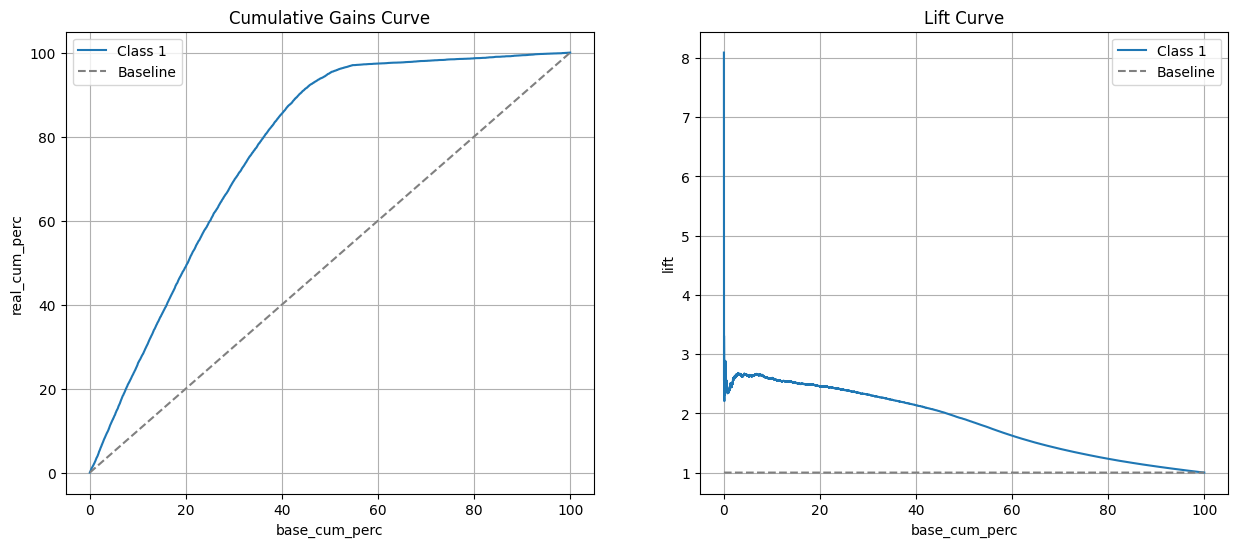

A precisão do modelo com 20000 chamadas é 29.39%
O recall do modelo com 20000 chamadas é 62.39%


In [100]:
curves(x_val, yhat_final, y_val, k)

In [101]:
print(f'O percentual de ligações feitas com 20 mil chamadas em relaçao a base total de validação é de {(k/y_val.size)*100:.2f}%')
print(f'Ou seja ao realizarmos contato com {(k/y_val.size)*100:.2f}% da base de clientes podemos localizar 64.55% dos clientes interessados')

O percentual de ligações feitas com 20 mil chamadas em relaçao a base total de validação é de 26.24%
Ou seja ao realizarmos contato com 26.24% da base de clientes podemos localizar 64.55% dos clientes interessados


# 9.0 Deploy

In [102]:
# Save trained model
pickle.dump( final_model, open(r'C:\Users\Matheus\Documents\projects\propensao_de_compra\models\model_random_forest.pkl', 'wb' ) )

## 9.1 Health Insurance Class

In [56]:
class HealthInsurance:
    
    def __init__( self ):
        self.home_path = r'C:\Users\Matheus\Documents\projects\propensao_de_compra'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + '/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + '/features/age_scaler.pkl', 'rb'  ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + '/features/vintage_scaler.pkl', 'rb'  ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + '/features/target_encode_gender_scaler.pkl', 'rb'  ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + '/features/target_encode_region_code_scaler.pkl', 'rb'  ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + '/features/fe_policy_sales_channel_scaler.pkl', 'rb'  ) )
  
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )
        
        # Feature Selection
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred[:, 0]
        original_data['score'] = pred[:, 1]
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2 API Handler

In [ ]:
# Load model
model_path = r'c:\Users\Matheus\Documents\projects\propensao_de_compra\models\model_random_forest.pkl'
try:
    model = pickle.load(open(model_path, 'rb'))
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Initialize API
app = Flask(__name__)

@app.route('/healthinsurance/predict', methods=['POST'])
def health_insurance_predict():

    data = request.get_json()
    
    # Determine the structure of the data
    if isinstance(data, dict):
        # Dictionary: Directly to DataFrame
        df = pd.DataFrame([data]) if not all(isinstance(v, list) for v in data.values()) else pd.DataFrame(data)
    elif isinstance(data, list):
        # List of dictionaries: Directly to DataFrame
        if all(isinstance(item, dict) for item in data):
            df = pd.DataFrame(data)
        else:
            # List of lists: Add column names manually
            df = pd.DataFrame(data, columns=['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'])
    else:
        return "Unsupported JSON format", 400  # Bad request if unsupported
    
    try:
        # Instantiate pipeline
        pipeline = HealthInsurance()

        # Apply transformations
        df1 = pipeline.data_cleaning(df)
        df2 = pipeline.feature_engineering(df1)
        df3 = pipeline.data_preparation(df2)

        # Get predictions
        df_response = pipeline.get_prediction(model, df, df3)

        # Return response
        return Response(df_response.to_json(orient='records'), status=200, mimetype='application/json')

    except Exception as e:
        return Response(f'{{"error": "{str(e)}"}}', status=500, mimetype='application/json')

if __name__ == '__main__':
    app.run('127.0.0.1', debug=True)

## 9.3 API Tester

In [38]:
import requests, json

In [39]:
df_test = x_val
df_test['response'] = y_val

In [40]:
df_test = df_test.sample(10)

In [41]:
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
127487,127488,Male,48,1,47.0,0,over_2_years,1,40600.0,124.0,288,0
70709,70710,Male,24,1,28.0,0,below_1_year,1,32506.0,150.0,211,0
60379,60380,Female,21,1,36.0,0,below_1_year,0,2630.0,152.0,217,0
356616,356617,Male,27,1,17.0,1,below_1_year,0,41727.0,152.0,202,0
139418,139419,Male,24,1,18.0,1,below_1_year,0,27077.0,152.0,44,0
17528,17529,Male,60,1,10.0,1,between_1_2_years,0,33189.0,26.0,252,0
352594,352595,Female,24,1,29.0,1,below_1_year,0,46116.0,152.0,54,0
85080,85081,Male,37,1,41.0,0,between_1_2_years,1,37549.0,26.0,265,0
330122,330123,Female,47,1,28.0,0,between_1_2_years,1,34519.0,26.0,108,0
288363,288364,Male,25,1,30.0,1,below_1_year,0,28126.0,152.0,11,0


In [72]:
'''model_path = r'c:\Users\Matheus\Documents\projects\propensao_de_compra\models\model_random_forest.pkl'
model = pickle.load(open(model_path, 'rb'))
pipeline = HealthInsurance()
df_test1 = pipeline.data_cleaning(df_test)
df_test2 = pipeline.feature_engineering(df_test1)
df_test3 = pipeline.data_preparation(df_test2)
prediction = pipeline.get_prediction(model, df_test, df_test3)'''

In [42]:
data = json.dumps(df_test.to_dict(orient='records'))

In [48]:
#API Call
#url = 'https://propdedcompra-8ba3f9ede417.herokuapp.com/'
url = 'http://127.0.0.1:5000/healthinsurance/predict'
header = {'Content-Type': 'application/json'}
r = requests.post( url=url, data=data, headers=header )
print('Status Code {}'.format( r.status_code ) )

Status Code 200


In [49]:
prediction = r.json()
d1 = pd.DataFrame(prediction)
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction,score
1,70710,Male,24,1,28.0,0,below_1_year,1,32506.0,150.0,211,0,0.969294,0.030706
7,85081,Male,37,1,41.0,0,between_1_2_years,1,37549.0,26.0,265,0,0.982665,0.017335
5,17529,Male,60,1,10.0,1,between_1_2_years,0,33189.0,26.0,252,0,0.986950,0.013050
8,330123,Female,47,1,28.0,0,between_1_2_years,1,34519.0,26.0,108,0,0.988240,0.011760
0,127488,Male,48,1,47.0,0,over_2_years,1,40600.0,124.0,288,0,0.991743,0.008257
